In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
from time import time

import seaborn as sns

print(os.listdir("../input"))

['heart.csv']


References:
- https://www.kaggle.com/rgoodman/elo-merchant-with-no-peeking-at-other-kernels
- My ML Donors Udacity Project
- https://github.com/dmitriyboyuk/sl_classifier_framework-master/blob/master/finding_opportunity_segment_v1.ipynb

## Exploratory Data Analysis

- age: The person's age in years
- sex: The person's sex (1 = male, 0 = female)
- cp: The chest pain experienced (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)
- trestbps: The person's resting blood pressure (mm Hg on admission to the hospital)
- chol: The person's cholesterol measurement in mg/dl
- fbs: The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)
- restecg: Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
- thalach: The person's maximum heart rate achieved
- exang: Exercise induced angina (1 = yes; 0 = no)
- oldpeak: ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot)
- slope: the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)
- ca: The number of major vessels (0-3)
- thal: A blood disorder called thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)
- target: Heart disease (0 = no, 1 = yes)

**Reading into the descriptions of the features of the dataset, it looks like a few of them should be reclassified as categoricals instead of numerical features.**
- cp
- restecg
- slope
- thal

In [2]:
df = pd.read_csv("../input/heart.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
df.shape

(303, 14)

There are only 303 records, and it's questionable as to whether this sample size will be enough to arrive at significant and reliable conclusions regarding the most important factors for heart disease.

In [4]:
categoricals = ['cp','restecg','slope','thal']
df[categoricals].head(2)

,cp,restecg,slope,thal
0,3,0,0,1
1,2,1,0,2


In [5]:
numerics = np.setdiff1d(df.columns.tolist(),categoricals)
df[numerics].head(3)

,age,ca,chol,exang,fbs,oldpeak,sex,target,thalach,trestbps
0,63,0,233,0,1,2.3,1,1,150,145
1,37,0,250,0,0,3.5,1,1,187,130
2,41,0,204,0,0,1.4,0,1,172,130


In [6]:
# There aren't any null values
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [7]:
df['thal'].max()

3

In [8]:
pd.get_dummies(df[categoricals].astype(str)).head()

,cp_0,cp_1,cp_2,cp_3,restecg_0,restecg_1,restecg_2,slope_0,slope_1,slope_2,thal_0,thal_1,thal_2,thal_3
0,0,0,0,1,1,0,0,1,0,0,0,1,0,0
1,0,0,1,0,0,1,0,1,0,0,0,0,1,0
2,0,1,0,0,1,0,0,0,0,1,0,0,1,0
3,0,1,0,0,0,1,0,0,0,1,0,0,1,0
4,1,0,0,0,0,1,0,0,0,1,0,0,1,0


Before passing the numerical features to the model, it's important to see if there is skewness in the distributions.

In [9]:
skew_calcs = df[numerics].skew()
skew_calcs[abs(skew_calcs)>0.7]

ca          1.310422
chol        1.143401
exang       0.742532
fbs         1.986652
oldpeak     1.269720
sex        -0.791335
trestbps    0.713768
dtype: float64

In [10]:
skewed_features = skew_calcs[skew_calcs.abs()>0.7].index.tolist()
skewed_features

['ca', 'chol', 'exang', 'fbs', 'oldpeak', 'sex', 'trestbps']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f611e500828>,
      dtype=object)

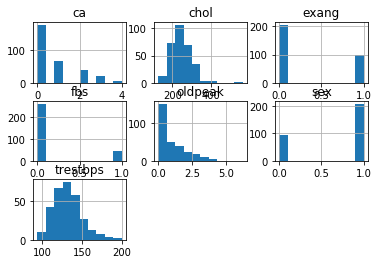

In [11]:
df[skewed_features].hist()

#### The distribution of log-transformed features below does not appear to improve the distribution to appear more "normal", so I will stick with the original features without any transformation.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f613447a198>,
      dtype=object)

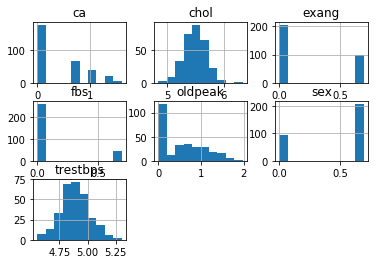

In [12]:
np.log1p(df[skewed_features]).hist()

In [13]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


**Created dummy variables for the categoricals and looks like everything merged/joined correctly.**

In [14]:
modeldata = pd.merge(df[numerics],pd.get_dummies(df[categoricals].astype(str)),left_index = True, right_index = True,how = 'inner')
modeldata.head()

,age,ca,chol,exang,fbs,oldpeak,sex,target,thalach,trestbps,cp_0,cp_1,cp_2,cp_3,restecg_0,restecg_1,restecg_2,slope_0,slope_1,slope_2,thal_0,thal_1,thal_2,thal_3
0,63,0,233,0,1,2.3,1,1,150,145,0,0,0,1,1,0,0,1,0,0,0,1,0,0
1,37,0,250,0,0,3.5,1,1,187,130,0,0,1,0,0,1,0,1,0,0,0,0,1,0
2,41,0,204,0,0,1.4,0,1,172,130,0,1,0,0,1,0,0,0,0,1,0,0,1,0
3,56,0,236,0,0,0.8,1,1,178,120,0,1,0,0,0,1,0,0,0,1,0,0,1,0
4,57,0,354,1,0,0.6,0,1,163,120,1,0,0,0,0,1,0,0,0,1,0,0,1,0


## Prep Model for Training and Validation

In [15]:
from sklearn.model_selection import train_test_split
X, y = modeldata.drop(['target'],axis = 1), modeldata['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [16]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import fbeta_score, accuracy_score

In [17]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    results = {}
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    results['train_time'] = end - start
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    results['pred_time'] = end - start
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,.5)
    results['f_test'] = fbeta_score(y_test,predictions_test,.5)
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
    return results

In [18]:
learners= []

from sklearn.linear_model import LogisticRegression
learners.append(LogisticRegression())

from sklearn.tree import DecisionTreeClassifier
learners.append(DecisionTreeClassifier())

from sklearn.neighbors import KNeighborsClassifier
learners.append(KNeighborsClassifier())

from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier 
learners.append(GradientBoostingClassifier())
learners.append(BaggingClassifier())
learners.append(RandomForestClassifier())

results = {}
for clf in learners:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    results[clf_name] = train_predict(clf, int(len(y_train)), X_train, y_train, X_test, y_test)

LogisticRegression trained on 242 samples.
DecisionTreeClassifier trained on 242 samples.
KNeighborsClassifier trained on 242 samples.
GradientBoostingClassifier trained on 242 samples.
BaggingClassifier trained on 242 samples.
RandomForestClassifier trained on 242 samples.


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [19]:
pd.DataFrame.from_dict(results).transpose()

,acc_test,acc_train,f_test,f_train,pred_time,train_time
LogisticRegression,0.770492,0.876033,0.724638,0.883171,0.002404,0.009445
DecisionTreeClassifier,0.770492,1.000000,0.719178,1.000000,0.002145,0.003288
KNeighborsClassifier,0.590164,0.780992,0.545977,0.798376,0.005548,0.003064
GradientBoostingClassifier,0.803279,0.995868,0.760870,0.994278,0.003365,0.072319
BaggingClassifier,0.770492,0.991736,0.719178,0.997089,0.004580,0.016742
RandomForestClassifier,0.786885,0.991736,0.739437,0.992806,0.004654,0.013856


Since the Bagging Classifier has the best results, I'll dig more into feature importance below.

In [20]:
model = BaggingClassifier()
model.fit(X,y)

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False)

In [21]:
clf = BaggingClassifier()
clf.fit(X, y)

importances = np.mean([
    tree.feature_importances_ for tree in clf.estimators_
], axis=0)

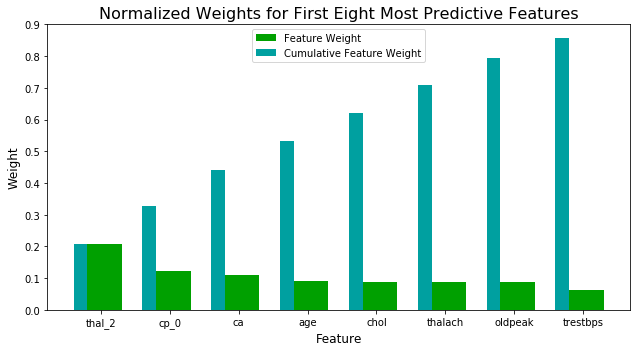

In [22]:
vars = 8
indices = np.argsort(importances)[::-1]
columns = X_train.columns.values[indices[:vars]]
values = importances[indices][:vars]
fig = pl.figure(figsize = (9,5))
pl.title("Normalized Weights for First Eight Most Predictive Features", fontsize = 16)
pl.bar(np.arange(vars), values, width = 0.6, align="center", color = '#00A000', \
      label = "Feature Weight")
pl.bar(np.arange(vars) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
      label = "Cumulative Feature Weight")
pl.xticks(np.arange(vars), columns)
pl.ylabel("Weight", fontsize = 12)
pl.xlabel("Feature", fontsize = 12)
pl.legend(loc = 'upper center')
pl.tight_layout()
pl.show()

In [23]:
### We observe the distribution of the top three most important features and can confirm their clear differentiated distribution between target and non-target groups
target1 = modeldata[modeldata['target']==1]
target0 = modeldata[modeldata['target']==0]

oldpeak


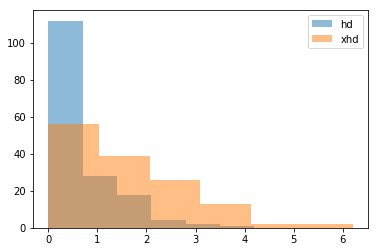

ca


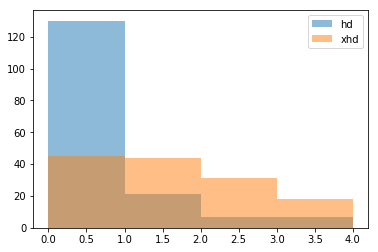

In [24]:
for i in ['oldpeak','ca']:
    print(i)
    plt.hist(target1[i],int(modeldata[i].max()),alpha = 0.5, label = 'hd')
    plt.hist(target0[i],int(modeldata[i].max()),alpha = 0.5, label = 'xhd')
    plt.legend(loc = 'upper right')
    plt.show()

**It looks like oldpeak and ca values of zero are positively correlated with the presence of heart disease.** We will also see this in the correlation table a bit below, where there are 4th and 5th most negatively correlated features.

In [25]:
thal2 = modeldata[['thal_2','target']]
thal2['combined'] = modeldata['thal_2'] * modeldata['target']
thal2.sum()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


thal_2      166
target      165
combined    130
dtype: int64

In [26]:
130/166

0.7831325301204819

In [27]:
pd.merge(pd.get_dummies(df['thal']), df[['target']], left_index = True, right_index = True, how = 'inner').corr()['target']

0        -0.007293
1        -0.106589
2         0.527334
3        -0.486112
target    1.000000
Name: target, dtype: float64

**About 78% of those with thal_2, thalassemia - reversable defect, had heart disease.  In the correlation table below, we see that this is the most highly correlated feature with heart disease.**

In [28]:
modeldata.corr()['target'].sort_values()

cp_0        -0.516015
thal_3      -0.486112
exang       -0.436757
oldpeak     -0.430696
ca          -0.391724
slope_1     -0.362053
sex         -0.280937
age         -0.225439
restecg_0   -0.159775
trestbps    -0.144931
thal_1      -0.106589
chol        -0.085239
restecg_2   -0.068410
slope_0     -0.063554
fbs         -0.028046
thal_0      -0.007293
cp_3         0.086957
restecg_1    0.175322
cp_1         0.245879
cp_2         0.316742
slope_2      0.394066
thalach      0.421741
thal_2       0.527334
target       1.000000
Name: target, dtype: float64

In [29]:
cp0 = modeldata[['cp_0','target']]
cp0['combined'] = modeldata['cp_0'] * modeldata['target']
cp0.sum()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


cp_0        143
target      165
combined     39
dtype: int64

In [30]:
39/143

0.2727272727272727

In [31]:
df['target'].sum()/df.shape[0]

0.5445544554455446

**In the same correlation chart, we see that cp_0, chest pain - typical angina, has the most negative correlation with the presence of heart disease.** Only 27% of those with typical angina had heart disease, whereas 54% of all individuals in the study had heart disease.

## So, let's summarize our findings and see if they make sense in the real world.

In [32]:
We see that values of zero for both oldpeak and ca are positively correlated with heart disease.
- oldpeak is the ST depression induced by exercise relative to rest.

SyntaxError: invalid syntax (<ipython-input-32-5522ce09d098>, line 1)

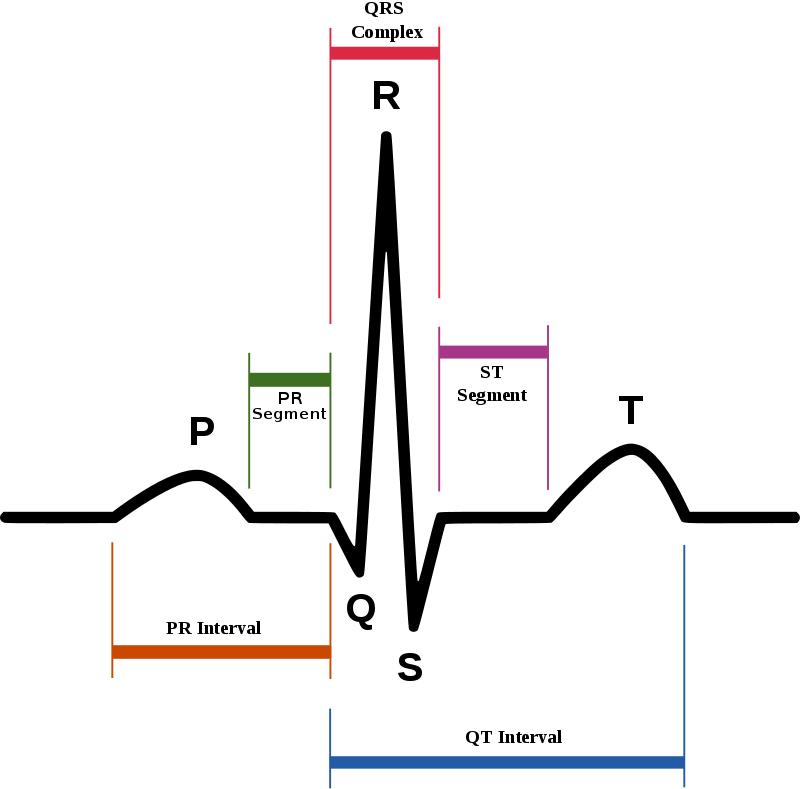


I'll have to trust the data on this one, since it looks like understanding the pattern above is a field in itself. https://ecg.utah.edu/

In [33]:
- ca is the number of major vessels (0-3) colored by flouroscopy.

SyntaxError: invalid syntax (<ipython-input-33-48c412928a8e>, line 1)

https://www.urmc.rochester.edu/encyclopedia/content.aspx?ContentTypeID=92&ContentID=p07662
Here we can see that the flouroscopy will show the flow of blood through coronary arteries to check for arterial blockages. From this, we can infer at a very simple level that have zero major vessels is a problem.  Having no major arteries will significantly limit blood flow throughout the body.

The high correlation between thal_2, thalassemia - reversible defect doesn't sound surprising.  It almost sounds as if anyone with a "defect" would by definition already have heart disease, but that doesn't appear to be the case, since 78% of those had heart disease in the study.  I wasn't able to find much more information online about this feature, which is just another example of how specialized a data scientist would need to be to understand this type of study.

As we saw earlier, typical angina has the most negative correlation with the presence of heart disease. Only 27% of those with typical angina had heart disease.  

Here is the breakdown of the types of angina in the study:
- typical angina
- atypical angina
- non-anginal pain
- asymptomatic

Angina is a type of chest pain cause by reduced blood flow to the heart.  Again, the correlations underlying these various types are most likely only to be well understood by someone with specialized training in medicine.

## Summary:
We data scientists like to find the answers to problems, but the problems we try to solve are often much more complex than applying your typical machine learning model and simply reading out results that revolutionize the world.  We still need to ask a lot of questions about the specific case.
- Does machine working work for this case? Is the sample size large enough for a machine learning application?
- Would a model work best for this, or should we just stick with descriptive statistics like averages and correlations?
- What is the specialized level of knowledge required to understand the results?
- Do the results corroborate the established understanding in this field? Why, or why not?

This is a great example of data science being a complementary tool to our understanding of various problems, whether social, medical, or anything else.  Our predictions may outperform those of those who specialize in a given field, but to really add value, it's important that we combine statistics, data science, and especially domain-specific expertise if we are to fully leverage the value the data science to its full potential.